# ML Workflow: Naive Bayes Classifier and  Support Vector Machine Pipelines
Module and data imports

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

#* 2 Datasets used throughout
from preprocess import twitter_df
celeb_df = pd.read_csv("CSV_files/celeb_tweets.csv")

## Preprocessing datasets: (celeb_df & twitter_df)

In [2]:
# Function to make all tweets lower case and remove special characters / punctuation 
def preprocess_text(text):
    return text.str.replace("'", "", regex=True).str.replace(r"[^a-zA-Z']", " ", regex=True).str.lower()
    # The first replace ensures words like don't get simplified to "dont" instead of "don t" 

twitter_df["Tweet"] = preprocess_text(twitter_df["Tweet"])
celeb_df["Tweet"] = preprocess_text(celeb_df["Tweet"])
# print(twitter_df.head())

counter = CountVectorizer(ngram_range=(1, 3))

## Creating NB and SVM Machine learning Pipelines


In [3]:
svm_pipeline = Pipeline([
    ('preprocess_text', counter),
    ('svm_classifier', LinearSVC(dual=True, max_iter=10000))
])

nb_pipeline = Pipeline([
    ('preprocess_text', counter),
    ('NB_classifier', MultinomialNB())
])

#? splitting data into training and test sets
X = twitter_df["Tweet"]
y = twitter_df["Target"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=303)

x_train_counts = counter.fit_transform(x_train)
x_test_counts = counter.transform(x_test)

#? Train SVM model and compute Confusion Matrix
svm_pipeline.fit(x_train, y_train)
svm_predictions = svm_pipeline.predict(x_test)
svm_cm = confusion_matrix(y_test, svm_predictions)

#? Train NB model and compute confusion matrix
nb_pipeline.fit(x_train, y_train)
nb_predictions = nb_pipeline.predict(x_test)
nb_cm = confusion_matrix(y_test, nb_predictions)

print("Confusion Matrix for SVM Model:")
print(svm_cm)

print("\nConfusion Matrix for NB Model:")
print(nb_cm)

Confusion Matrix for SVM Model:
[[3043  913]
 [ 855 3189]]

Confusion Matrix for Naive Bayes Model:
[[3302  654]
 [1226 2818]]


## Define parameter grids for GridSearchCV and RandomizedSearchCV

In [4]:
param_grid_svm = {
    'svm_classifier__C': [0.01, 0.1, 1, 10],  # Hyperparameters for SVM
}
param_grid_nb = {
    'NB_classifier__alpha': [0.1, 0.5, 1.0]   # Hyperparameters for Naive Bayes
}

# NB using GridSearchCV
grid_search_nb = GridSearchCV(nb_pipeline, param_grid_nb, cv=5)
grid_search_nb.fit(x_train, y_train)

# SVM using RandomizedSearchCV
randomized_search_svm = RandomizedSearchCV(svm_pipeline, param_grid_svm, n_iter=3, cv=5)
randomized_search_svm.fit(x_train, y_train)

#? Best parameters and score for NB
print("Best Parameters (NB):", grid_search_nb.best_params_)
print("Best Score (NB):", round(100 * grid_search_nb.best_score_, 2))
print("Accuracy (NB):", round(100 * grid_search_nb.score(x_test, y_test), 2), "\n")

#? Best parameters and score for SVM
print("Best Parameters (SVM):", randomized_search_svm.best_params_)
print("Best Score (SVM):", round(100 * randomized_search_svm.best_score_, 2))
print("Accuracy (SVM):", round(100 * randomized_search_svm.score(x_test, y_test), 2))

# (Takes roughly 1min 10 to run)

Best Parameters (NB): {'NB_classifier__alpha': 1.0}
Best Score (NB): 75.34
Accuracy (NB): 76.5 

Best Parameters (SVM): {'svm_classifier__C': 0.1}
Best Score (SVM): 77.66
Accuracy (SVM): 78.56


## Naive Bayes Classifier: Predictions and Visualisation

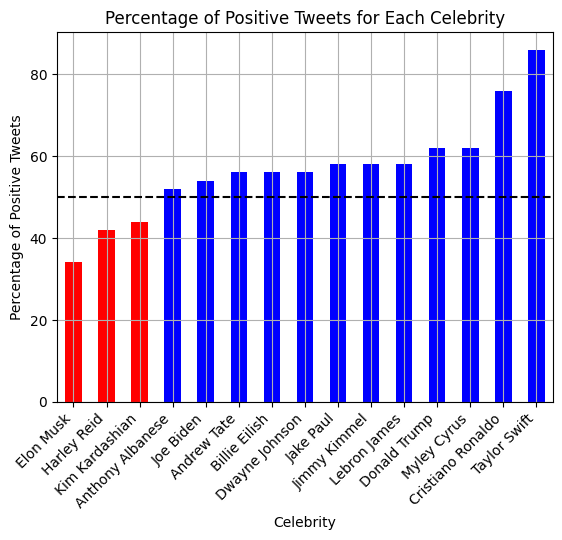

In [5]:
# Predictions using NB
predictions_nb = grid_search_nb.predict(celeb_df.Tweet)
celeb_df["NB_Predict"] = predictions_nb
celeb_df.to_csv("Celebrity_Data/celeb_predict.csv")
celeb_target_counts = celeb_df.groupby("Celebrity")["NB_Predict"].value_counts()

#? Graphing
positive_counts = celeb_target_counts.unstack().get(1, 0).sort_values() * 2 # x2 so they are a percentage
colors = ['red' if count < 50 else 'blue' for count in positive_counts]
positive_counts.plot(kind='bar', color=colors)

plt.xlabel('Celebrity')
plt.ylabel('Percentage of Positive Tweets')
plt.title('Percentage of Positive Tweets for Each Celebrity')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=50, color='black', linestyle='--')
plt.grid(True)
plt.show()

## Support Vector Machines: Predictions and Visualisation

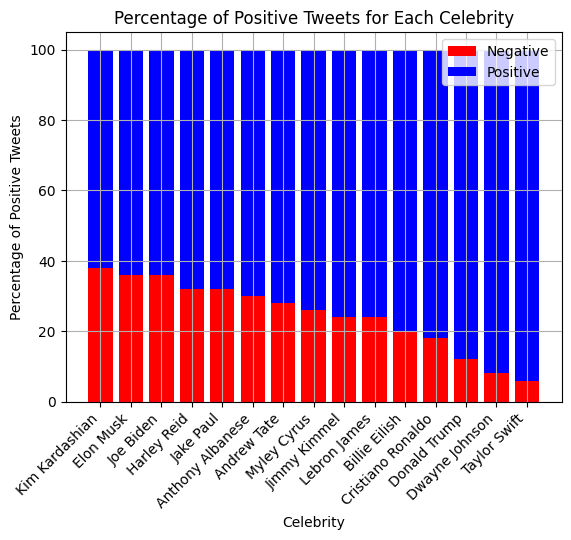

In [6]:
# Predictions using SVM
predictions_svm = randomized_search_svm.predict(celeb_df.Tweet)
celeb_df["SVM_Predict"] = predictions_svm
celeb_df.to_csv("Celebrity_Data/celeb_predict.csv")
celeb_target_counts = celeb_df.groupby("Celebrity")["SVM_Predict"].value_counts()

#? Graphing
positive_counts = celeb_target_counts.unstack().get(1, 0).sort_values() * 2 # So they are a percentage
negative_counts = 100 - positive_counts 
plt.bar(positive_counts.index, negative_counts, color='red')
plt.bar(positive_counts.index, positive_counts, bottom=negative_counts, color='blue')

plt.xlabel('Celebrity')
plt.ylabel('Percentage of Positive Tweets')
plt.title('Percentage of Positive Tweets for Each Celebrity')
plt.legend(['Negative', 'Positive'], loc='upper right')
plt.xticks(rotation=45, ha='right')
# plt.axhline(y=50, color='black', linestyle='--')
plt.grid(True)
plt.show()

# Conclusion:

The analysis of the project suggests that despite exhibiting a positivity bias in its predictions, the SVM model demonstrated higher overall accuracy compared to the Naive Bayes model. Visualizations indicate that tweets referencing celebrities such as Taylor Swift, Cristiano Ronaldo, and Donald Trump tended to be more positive on average. Conversely, tweets mentioning Elon Musk, Kim Kardashian, and Harley Reid tended to have a more negative sentiment. These findings offer valuable insights into the sentiment dynamics surrounding different celebrities on Twitter.
